In [65]:
import pandas as pd
import numpy as np
from sklearn import decomposition

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='white')
%matplotlib inline

### MovieLens 100k DataSet

В датасете представленны 100k оценок от 1k пользователей по 1.7k фильмам

Данные предсталвенны в виде таблицы со столбцами userID, itemID, rating и timestamp

In [13]:
database = pd.read_csv('ml-100k/u.data', sep='\t', header=None, names=['userID', 'itemID', 'rating', 'timestamp'])

In [14]:
database.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [17]:
database.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
userID       100000 non-null int64
itemID       100000 non-null int64
rating       100000 non-null int64
timestamp    100000 non-null int64
dtypes: int64(4)
memory usage: 3.1 MB


In [26]:
n_users = database.userID.unique().shape[0]
n_items = database.itemID.unique().shape[0]

In [27]:
print 'Number of users:  ' +  str(n_users)
print 'Number of movies: ' +  str(n_items)

Number of users:  943
Number of movies: 1682


Представим таблицу в виде матрицы, строки которой соответствуют пользователям, а столбцы фильмам.
Тогда элемент матрицы Rui представляет собой оценку пользователя 'u' фильму 'i'

In [30]:
data_matrix = np.zeros((n_users, n_items))
for line in database.itertuples():
    data_matrix[line[1]-1, line[2]-1] = line[3]

In [55]:
print data_matrix.shape
pd.DataFrame(data_matrix).head()

(943L, 1682L)


,0,1,2,3,4,5,6,7,8,9,...,1672,1673,1674,1675,1676,1677,1678,1679,1680,1681
0,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Разделим матрицу на две части: обучающую выборку и проверочную. В соотношениие 3 к 1

In [486]:
from sklearn.model_selection  import train_test_split as cv
train_data, test_data = cv(data_matrix, test_size=0.25)

print 'Train shape: ' + str(train_data.shape)
print 'Test  shape: ' + str(test_data.shape)

Train shape: (707L, 1682L)
Test  shape: (236L, 1682L)


#### Первый подход Коллаборативной Фильтрации основанный на разбиении пользователей\объектов на кластеры
Пробуем 3 варианта кластеризации со стандартными параметрами: kmeans, affinity propagation и affinity propagation с заданной матрицей схожести

In [103]:
from sklearn.cluster import KMeans, AffinityPropagation

In [147]:
kmeans = KMeans().fit(train_data)
print kmeans.get_params
print len(kmeans.labels_)

<bound method KMeans.get_params of KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)>
707


In [148]:
affinity = AffinityPropagation().fit(train_data)
print affinity.get_params()
print pd.Series(affinity.labels_).value_counts().unique()

{'verbose': False, 'max_iter': 200, 'affinity': 'euclidean', 'damping': 0.5, 'copy': True, 'convergence_iter': 15, 'preference': None}
[175  73  69  64  48  46  24  23  18  15   9   6   1]


In [427]:
from sklearn.metrics.pairwise import pairwise_distances
user_similarity = pairwise_distances(train_data, metric='cosine')

affinity_precomp = AffinityPropagation(affinity='precomputed').fit(user_similarity)
print affinity_precomp.get_params()
print pd.Series(affinity_precomp.labels_).value_counts().unique()

{'verbose': False, 'max_iter': 200, 'affinity': 'precomputed', 'damping': 0.5, 'copy': True, 'convergence_iter': 15, 'preference': None}
[159 115 110 107  67  60  55  34]


Отобразим данные на плоскость и раскрасим соответственно кластерам

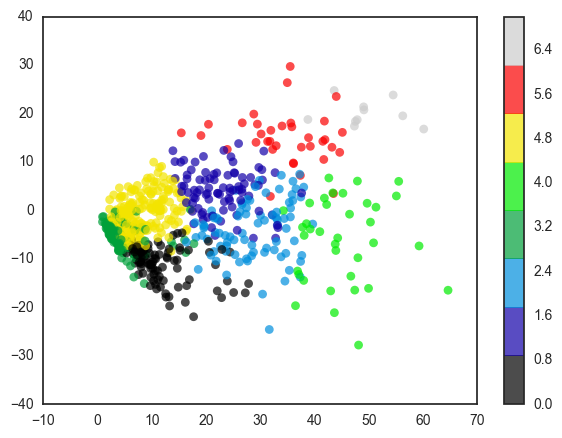

In [149]:
y = kmeans.labels_
pca = decomposition.TruncatedSVD(n_components=2)
X_reduced = pca.fit_transform(train_data)

plt.figure(figsize=(7,5))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 8))
plt.colorbar()

In [480]:
def pred_score_by_clusters(train_data, test_data, clusters_center, cluster_labels):
    # Относим новых пользователей к одному из имеющихся кластеров
    # пользователь пренадлежит тому кластеру, к центру которого он ближе всего
    test_labels = []
    for sample in range(test_data.shape[0]):
        test_sample = test_data[sample].reshape(1,-1)
        test_label = pairwise_distances(clusters_center, test_sample, metric='euclidean').argmin()
        test_labels.append(test_label)
        
    # Предсказываем оценки пользователей, как среднюю оценку кластера пользователя по данному предмету    
    pred_data = np.zeros((test_data.shape[0], test_data.shape[1]))
    test_labels = pd.Series(test_labels)
    for label in cluster_labels.unique():
        test_index = test_labels[test_labels == label].index
        cluster_index = cluster_labels[cluster_labels == label].index
        
        pred_data[test_index] = train_data[cluster_index].mean(axis=0)

    #pred_data = pred_data.as_matrix()    
    return pred_data

In [482]:
%%time
pred_kmeans = pred_score_by_clusters(train_data, test_data, kmeans.cluster_centers_, pd.Series(kmeans.labels_))

Wall time: 74 ms


In [483]:
%%time
pred_affinity = pred_score_by_clusters(train_data, test_data, affinity.cluster_centers_, pd.Series(affinity.labels_))

Wall time: 533 ms


In [484]:
%%time
pred_affinity_precomp = pred_score_by_clusters(train_data, test_data, \
                                               train_data[affinity_precomp.cluster_centers_indices_],\
                                               pd.Series(affinity_precomp.labels_))

Wall time: 85 ms


In [404]:
from sklearn.metrics import mean_squared_error
from math import sqrt
def rmse(y_pred, y_true):
    y_pred = y_pred[y_true.nonzero()]
    y_true = y_true[y_true.nonzero()]
    return sqrt(mean_squared_error(y_pred, y_true))

#### Второй подход user-based \ item-based коллаборативная фильтрация
$ x _k,_m=x¯_k+∑_u,_a sim_u(u_k,u_a)(x_a,_m−x¯_u,_a) / ∑u_a|sim_u(u_k,u_a)|$

Введем метрику похожести:
 * для пользователей - косинусное расстоние
 * для фильмов - корреляция Пирсона 

In [438]:
user_similarity = pairwise_distances(train_data, metric='cosine')
item_similarity = pairwise_distances(train_data.T, metric='correlation')

In [511]:
def predict(ratings, similarity, type='user'):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis])
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        mean_item_rating = ratings.mean(axis=0)
        ratings_diff = (ratings.T - mean_item_rating[:, np.newaxis])
        pred = mean_item_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
        pred = pred.T
    return pred

In [512]:
item_prediction = predict(train_data, item_similarity, type='item')
user_prediction = predict(train_data, user_similarity, type='user')

#### Третий подход основан на SVD - сингулярное разложение матрицы
Идея заключается в том, что мы можем разложить имеющуюся матрицу с оценками на две низкоразмерные матрицы соответствующие пользователям и фильмам. Их произведение и даст предсказания оценок.

<img src="https://image.slidesharecdn.com/essir2013recsysfinal-130906083214-/95/essir-2013-recommender-systems-tutorial-63-638.jpg">

In [536]:
%run matrix_factorization.py
%matplotlib inline

Проблема заключается в том, что нам не известна полностью матрица с оценками.
Поэтому будем использоваться SGD для обучения и после делать предсказания

In [553]:
train, test = train_test_split(data_matrix)

MF_SGD = ExplicitMF(train, 40, learning='sgd', verbose=True)
iter_array = [1, 2, 5, 10, 25]
MF_SGD.calculate_learning_curve(iter_array, test, learning_rate=0.01)

Iteration: 1
Train mse: 0.920394652914
Test mse: 1.00059173171
Iteration: 2
Train mse: 0.878737682579
Test mse: 0.963673274617
Iteration: 5
Train mse: 0.840215238102
Test mse: 0.93940754516
Iteration: 10
Train mse: 0.74840913178
Test mse: 0.914601782458
Iteration: 25
	current iteration: 10
Train mse: 0.301404140319
Test mse: 0.951572568798


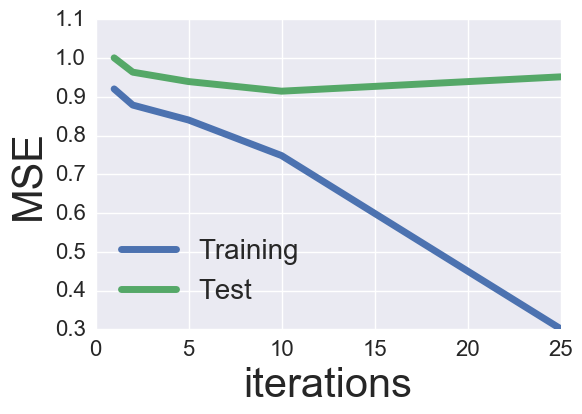

In [554]:
plot_learning_curve(iter_array, MF_SGD)

Найдем гиперпараметры для модели. Подбирать гиперпараметры будем жадным поиском
   * сначала найдем оптимальный learning rate
   * затем будем оптимизировать остальные параметры модели.

In [557]:
iter_array = [5, 10, 15]
learning_rates = [1e-4, 1e-3, 1e-2]

best_params = {}
best_params['learning_rate'] = None
best_params['n_iter'] = 0
best_params['train_mse'] = np.inf
best_params['test_mse'] = np.inf
best_params['model'] = None


for rate in learning_rates:
    print 'Rate: {}'.format(rate)
    MF_SGD = ExplicitMF(train, n_factors=40, learning='sgd')
    MF_SGD.calculate_learning_curve(iter_array, test, learning_rate=rate)
    min_idx = np.argmin(MF_SGD.test_mse)
    if MF_SGD.test_mse[min_idx] < best_params['test_mse']:
        best_params['n_iter'] = iter_array[min_idx]
        best_params['learning_rate'] = rate
        best_params['train_mse'] = MF_SGD.train_mse[min_idx]
        best_params['test_mse'] = MF_SGD.test_mse[min_idx]
        best_params['model'] = MF_SGD
        print 'New optimal hyperparameters'
        print pd.Series(best_params)

Rate: 0.0001
New optimal hyperparameters
learning_rate                                               0.0001
model            <__main__.ExplicitMF instance at 0x000000001C5...
n_iter                                                          15
test_mse                                                     1.146
train_mse                                                  1.10406
dtype: object
Rate: 0.001
New optimal hyperparameters
learning_rate                                                0.001
model            <__main__.ExplicitMF instance at 0x000000001C5...
n_iter                                                          15
test_mse                                                  0.975972
train_mse                                                 0.892988
dtype: object
Rate: 0.01
New optimal hyperparameters
learning_rate                                                 0.01
model            <__main__.ExplicitMF instance at 0x000000001C5...
n_iter                                          

In [558]:
iter_array = [10, 25, 50]
latent_factors = [20, 40, 80]
regularizations = [0.01, 0.1, 1.]
regularizations.sort()

best_params = {}
best_params['n_factors'] = latent_factors[0]
best_params['reg'] = regularizations[0]
best_params['n_iter'] = 0
best_params['train_mse'] = np.inf
best_params['test_mse'] = np.inf
best_params['model'] = None

for fact in latent_factors:
    print 'Factors: {}'.format(fact)
    for reg in regularizations:
        print 'Regularization: {}'.format(reg)
        MF_SGD = ExplicitMF(train, n_factors=fact, learning='sgd',\
                            user_fact_reg=reg, item_fact_reg=reg, \
                            user_bias_reg=reg, item_bias_reg=reg)
        MF_SGD.calculate_learning_curve(iter_array, test, learning_rate=0.001)
        min_idx = np.argmin(MF_SGD.test_mse)
        if MF_SGD.test_mse[min_idx] < best_params['test_mse']:
            best_params['n_factors'] = fact
            best_params['reg'] = reg
            best_params['n_iter'] = iter_array[min_idx]
            best_params['train_mse'] = MF_SGD.train_mse[min_idx]
            best_params['test_mse'] = MF_SGD.test_mse[min_idx]
            best_params['model'] = MF_SGD
            print 'New optimal hyperparameters'
            print pd.Series(best_params)

Factors: 20
Regularization: 0.01
New optimal hyperparameters
model        <__main__.ExplicitMF instance at 0x000000001C5...
n_factors                                                   20
n_iter                                                      50
reg                                                       0.01
test_mse                                              0.935945
train_mse                                             0.835305
dtype: object
Regularization: 0.1
Regularization: 1.0
Factors: 40
Regularization: 0.01
Regularization: 0.1
Regularization: 1.0
Factors: 80
Regularization: 0.01
Regularization: 0.1
Regularization: 1.0


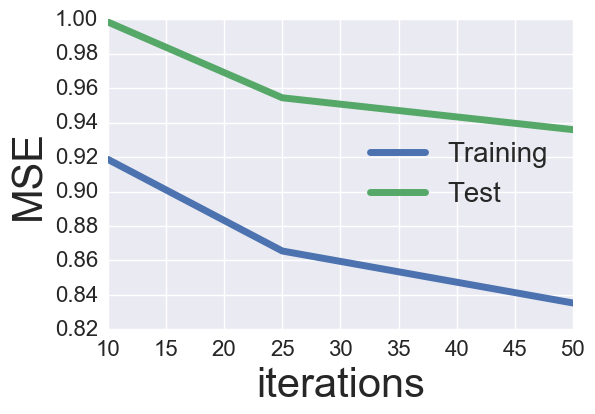

In [560]:
plot_learning_curve(iter_array, best_params['model'])

In [561]:
print 'Best regularization: {}'.format(best_params['reg'])
print 'Best latent factors: {}'.format(best_params['n_factors'])
print 'Best iterations: {}'.format(best_params['n_iter'])

Best regularization: 0.01
Best latent factors: 20
Best iterations: 50


Проверим качество всех моделей метрикой RMSE:

In [563]:
print 'k-means CF algo              : ' + str(rmse(pred_kmeans, test_data))
print 'AP CF algo                   : ' + str(rmse(pred_affinity, test_data))
print 'AP precomputed CF algo       : ' + str(rmse(pred_affinity_precomp, test_data))

print 'user-based CF                : ' + str(rmse(user_prediction, test_data))
print 'item-based CF                : ' + str(rmse(item_prediction, test_data))

print 'Matrix Factorization + SGD CF: ' + str(rmse(MF_SGD.predict_all(), test_data))

k-means CF algo              : 3.17667070498
AP CF algo                   : 3.24696893267
AP precomputed CF algo       : 3.07990410557
user-based CF                : 3.05770894363
item-based CF                : 3.05760480939
Matrix Factorization + SGD CF: 1.08571934363
